In [17]:
! pip install langgraph langsmith

In [18]:
!pip install langchain langchain-groq langchain-community

In [19]:
import os
from google.colab import userdata

LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')

os.environ['LANGCHAIN_API_KEY']=LANGCHAIN_API_KEY
os.environ['LANGCHAIN_TRACING_V2']="true"
os.environ['LANGCHAIN_PROJECT']="LiveLanggraph"

In [20]:
from langchain_groq import ChatGroq

GROQ_API_KEY = userdata.get('GROQ_API_KEY')

In [21]:
llm = ChatGroq(groq_api_key=GROQ_API_KEY, model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7c2e826b7490>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7c2e82dab010>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [22]:
# Simple chatbot using Langgraph
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [23]:
class State(TypedDict):
  # Messages have the type "list". The `add_messages` function in the annotation defines
  # how this state key should be updated
  # (in this case, it appends messages to the list, rather than overwriting them)
  messages:Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [24]:
def chatbot(state: State):
  return {"messages": [llm.invoke(state["messages"])]}

In [25]:
graph_builder.add_node("chatbot", chatbot)

In [26]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [27]:
graph = graph_builder.compile()

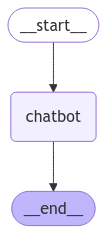

In [28]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [29]:
while True:
  user_input = input("User:")
  if user_input.lower() in ["quit", "q"]:
    print("Good Bye")
    break

  for event in graph.stream({'messages':("user", user_input)}):
    print(event.values())
    for value in event.values():
      print(value['messages'])
      print("Assistant :", value["messages"][-1].content )

User:hi
dict_values([{'messages': [AIMessage(content='Hello! 👋  How can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 10, 'total_tokens': 25, 'completion_time': 0.027272727, 'prompt_time': 3.4e-07, 'queue_time': 0.020597586999999997, 'total_time': 0.027273067}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-292000cf-f013-48ab-9987-c3e53017d49e-0', usage_metadata={'input_tokens': 10, 'output_tokens': 15, 'total_tokens': 25})]}])
[AIMessage(content='Hello! 👋  How can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 10, 'total_tokens': 25, 'completion_time': 0.027272727, 'prompt_time': 3.4e-07, 'queue_time': 0.020597586999999997, 'total_time': 0.027273067}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None},

# Graph with Multiple Nodes

In [30]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [31]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.9 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=6826cfe72397629004ecc4b14ad07507d0724efeed82281a22a46252231daffa
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=0b08d03ea66e301c2ca5c20769feb97bb7b439e805541b54a323da35e9ef34a9
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


In [34]:
# Working with Tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

# Arxiv and Wikipedia Tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)
wiki = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [33]:
wiki.invoke("what is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and gen'

In [73]:
tools = [wiki, arxiv]

In [74]:
class State(TypedDict):
  messages:Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm_with_tools = llm.bind_tools(tools=tools)

In [75]:
def chatbot(state: State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [76]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

In [77]:
graph = graph_builder.compile()

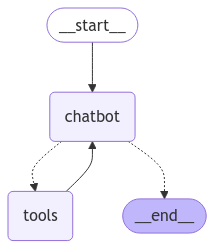

In [78]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [79]:
user_input = "In IT industry which role is getting highest payed in Software Engineer, Data Scientist and Machine Learnig Engineer"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)

for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

In IT industry which role is getting highest payed in Software Engineer, Data Scientist and Machine Learnig Engineer
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_brjp)
 Call ID: call_brjp
  Args:
    query: Highest paying job in IT
================================= Tool Message =================================
Name: wikipedia

Page: Fiverr
Summary: Fiverr is an Israeli multinational online marketplace for freelance services. Fiverr's connects freelancers (sellers) to people or businesses looking for services. Fiverr takes i
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_tt7r)
 Call ID: call_tt7r
  Args:
    query: highest paying tech jobs
================================= Tool Message =================================
Name: wikipedia

Page: Steve Jobs
Summary: Steven Paul Jobs